<a href="https://colab.research.google.com/github/Ssurf777/physics_informed_neural_network/blob/main/%E5%AE%9A%E5%B8%B8%E7%82%B9%E7%86%B1%E6%BA%90_%E7%86%B1%E6%8B%A1%E6%95%A3%E6%96%B9%E7%A8%8B%E5%BC%8FPINN(%E2%88%87%5E2T%2Bq_k%C3%97%CE%B4(r_r0)).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 定常の点熱源の熱拡散方程式について

定常状態で点熱源を含む熱拡散方程式について、以下のように表現できます：

#### 熱拡散方程式（定常状態）

定常状態では、時間変化がないため、熱伝導方程式は次のように書けます：

$$
\nabla^2 T = 0
$$

ここで、$T$ は温度場、$\nabla^2$ はラプラシアン（空間的な2階微分）です。

#### 点熱源の影響

点熱源が存在する場合、この点熱源を表すためにデルタ関数$(\delta(\mathbf{r} - \mathbf{r_0})$）を用います。デルタ関数は、点熱源が位置 $\mathbf{r_0}$ に集中していることを示します。点熱源の強さは $q$ とし、熱伝導率を $k$ とした場合、熱拡散方程式は次のように修正されます：

$$
\nabla^2 T = -\frac{q}{k} \delta(\mathbf{r} - \mathbf{r_0})
$$

ここで、$\delta(\mathbf{r} - \mathbf{r_0})$ は、点熱源の位置 $\mathbf{r_0}$ におけるデルタ関数です。

#### 定常熱拡散方程式の変形


$$
\nabla^2 T + \frac{q}{k} \delta(\mathbf{r} - \mathbf{r_0}) = 0
$$

は、上記の式と等価です。デルタ関数を右辺に移項させた形式であり、同じ物理的意味を持っています。

#### まとめ

- 「$\nabla^2 T + \frac{q}{k} \delta(\mathbf{r} - \mathbf{r_0}) = 0$」は、熱拡散方程式をデルタ関数を用いて表現した形として適切です。これが点熱源の影響を加味した定常状態の熱拡散方程式となります。
- 実際の数値計算では、デルタ関数をガウス関数で近似することが一般的です。

この形式を損失関数として学習することで、点熱源の影響を正しく反映させることができます。


### ①について：

このコードでは損失関数として、$\nabla^2 T + \frac{q}{k} \delta(\mathbf{r} - \mathbf{r_0}) = 0$ の形が学習されています。
具体的には、コード内で次のように学習が行われています。

1. **ラプラシアン項（$\nabla^2 T$）の計算**：`compute_laplacian_fd`関数内で、温度場 $T$ の2階微分（ラプラシアン）が有限差分法によって計算されます。このラプラシアン項は、定常熱拡散方程式の $\nabla^2 T$ に対応します。

2. **δ関数項（$\delta(\mathbf{r} - \mathbf{r_0})$）の近似**：`autograd_train_pinn`関数内では、点熱源を模倣するために、ガウス分布を用いてディラックのδ関数を近似しています。この近似は次の式で計算されています。
   $$
   \delta_{\text{approx}} = \frac{\exp\left(-\frac{(\mathbf{r} - \mathbf{r_0})^2}{2 \epsilon^2}\right)}{\epsilon \sqrt{2 \pi}}
   $$
   ここで、$\epsilon$はガウス分布の幅です。

このように、損失関数にはラプラシアン項と、点熱源を近似するガウス項が含まれており、結果的に式 $\nabla^2 T + \frac{q}{k} \delta(\mathbf{r} - \mathbf{r_0}) = 0$ に基づいて学習しています。

### ②について：

δ関数は理論的に微分できませんが、数値計算や近似においてはガウス分布を使うことが一般的です。ガウス関数は非常に尖ったピークを持つため、ディラックδ関数の近似として有効です。具体的には、次の点で近似が妥当です。

- **近似の形**：ガウス関数は、点熱源（デルタ関数）を近似するための標準的な手法です。ガウス関数の形はデルタ関数が$\epsilon \to 0$ の場合に一致します。
- **正規化**：近似されたガウス関数は、$\sum \delta_{\text{approx}} = 1$ となるように正規化されており、積分が1になる特性を持ちます。

この近似は、数値計算でデルタ関数を扱うために十分妥当であると考えられます。

### まとめ：
- 損失関数は$\nabla^2 T + \frac{q}{k} \delta(\mathbf{r} - \mathbf{r_0}) = 0$の形で学習しています。
- 質問②では、δ関数の近似としてガウス関数を使用するアプローチは適切です。


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import random

# シードの設定
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

# 球体の点群生成関数
def create_points(num_points=3000, radius=1.0):
    theta = torch.rand(num_points) * 2 * torch.pi
    phi = torch.acos(2 * torch.rand(num_points) - 1)

    x = radius * torch.sin(phi) * torch.cos(theta)
    y = radius * torch.sin(phi) * torch.sin(theta)
    z = radius * torch.cos(phi)

    points = torch.stack([x, y, z], dim=1)
    normalized_points = (points - points.min(dim=0)[0]) / (points.max(dim=0)[0] - points.min(dim=0)[0])
    return normalized_points

# ラプラシアン計算
# 有限差分法で２階微分を解く
def compute_laplacian_fd(model, points, h=1e-4):
    # 点群に微小変位を加える
    x = points.clone()
    x.requires_grad_(True)

    # 温度場の計算
    T = model(x)

    # 微小変位を加えて有限差分で二階微分を近似
    laplacian = torch.zeros_like(T)
    for i in range(points.shape[1]):
        dx = torch.zeros_like(points)
        dx[:, i] = h

        T_forward = model(x + dx)
        T_backward = model(x - dx)

        laplacian += (T_forward - 2 * T + T_backward) / (h**2)

    return laplacian.mean()



# PINNモデル定義
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)

        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc4.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x.float()))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# 学習関数 (バッチ処理対応)
def autograd_train_pinn(model, points, heat_source, epochs=100, batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    points = points.to(device)
    heat_source = heat_source.to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    start_time = time.time()

    laplacian_log, delta_log = [], []
    num_batches = (len(points) + batch_size - 1) // batch_size

    for epoch in range(epochs):
        model.train()
        total_loss, total_laplacian_loss, total_delta_loss = 0, 0, 0

        for i in range(num_batches):
            batch = points[i * batch_size:(i + 1) * batch_size]
            distances = torch.norm(batch - heat_source, dim=1)

            epsilon = 0.15
            delta_approx = torch.exp(-(distances**2) / (2 * epsilon**2)) / (epsilon * np.sqrt(2 * np.pi)) #ディラックδ関数
            delta_approx /= torch.sum(delta_approx)  # 積分が1になるように正規化
            heat_source_term = delta_approx


            laplacian_fd = compute_laplacian_fd(model, batch)
            loss_laplacian = torch.mean(torch.abs(laplacian_fd)*1e-4)  # スケールの調整
            loss_temperature = torch.mean(heat_source_term)

            loss = loss_laplacian + loss_temperature

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_laplacian_loss += loss_laplacian.item()
            total_delta_loss += loss_temperature.item()

        laplacian_log.append(total_laplacian_loss / len(points))
        delta_log.append(total_delta_loss / len(points))

        if epoch % 10 == 0:
            elapsed_time = time.time() - start_time
            print(f"Epoch {epoch}/{epochs} | Laplacian Loss: {total_laplacian_loss:.6e} | delta_Loss: {total_delta_loss:.6e} | Loss: {total_loss:.6e} | Time: {elapsed_time:.2f}s")

    return laplacian_log, delta_log


Epoch 0/100 | Laplacian Loss: 1.162191e-01 | delta_Loss: 7.366071e-01 | Loss: 8.528262e-01 | Time: 1.24s
Epoch 10/100 | Laplacian Loss: 1.133573e-01 | delta_Loss: 7.366071e-01 | Loss: 8.499644e-01 | Time: 4.20s
Epoch 20/100 | Laplacian Loss: 7.595384e-02 | delta_Loss: 7.366071e-01 | Loss: 8.125610e-01 | Time: 7.17s
Epoch 30/100 | Laplacian Loss: 1.122570e-01 | delta_Loss: 7.366071e-01 | Loss: 8.488641e-01 | Time: 10.18s
Epoch 40/100 | Laplacian Loss: 8.859040e-02 | delta_Loss: 7.366071e-01 | Loss: 8.251975e-01 | Time: 13.82s
Epoch 50/100 | Laplacian Loss: 1.016535e-01 | delta_Loss: 7.366071e-01 | Loss: 8.382607e-01 | Time: 16.92s
Epoch 60/100 | Laplacian Loss: 9.111312e-02 | delta_Loss: 7.366071e-01 | Loss: 8.277202e-01 | Time: 19.82s
Epoch 70/100 | Laplacian Loss: 7.585988e-02 | delta_Loss: 7.366071e-01 | Loss: 8.124670e-01 | Time: 22.78s
Epoch 80/100 | Laplacian Loss: 9.659012e-02 | delta_Loss: 7.366071e-01 | Loss: 8.331973e-01 | Time: 26.50s
Epoch 90/100 | Laplacian Loss: 1.082089e-

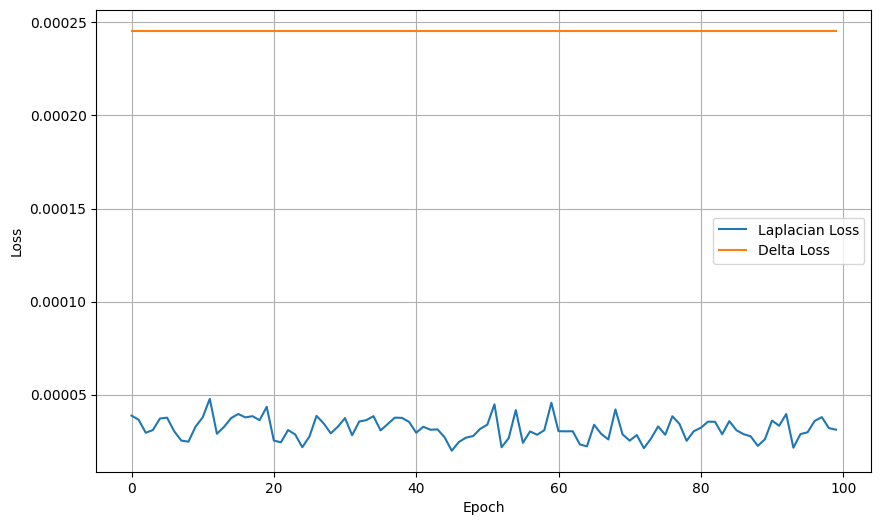

In [ ]:

# 球体点群生成とモデル学習
points = create_points(3000)
model = PINN()
laplacian_log, delta_log = autograd_train_pinn(model, points, torch.tensor([0, 0, 0]))

# 結果のプロット
plt.figure(figsize=(10, 6))
plt.plot(laplacian_log, label='Laplacian Loss')
plt.plot(delta_log, label='Delta Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


-0.01397046446800232
-1.460413932800293


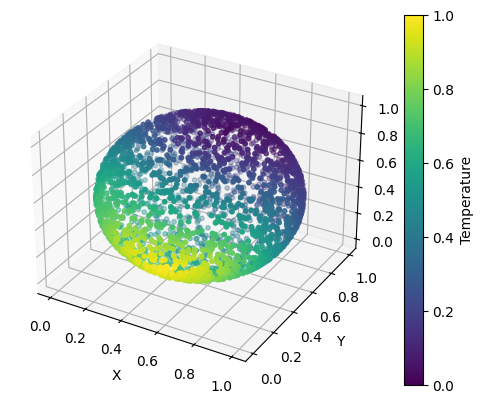

In [ ]:
import plotly.graph_objects as go
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルをデバイスに転送
model.to(device)

# 球上の点群を生成
points = create_points(num_points=3000, radius=1.0).to(device)
#points = create_chair_points().to(device)
# 温度推論
with torch.no_grad():
    predicted_temperatures = model(points).cpu().numpy().astype(float)  # データ型を指定
    predicted_temperatures =  predicted_temperatures

print(predicted_temperatures.max())
print(predicted_temperatures.min())


# 3Dプロットのセットアップ
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
normalized_temp = (predicted_temperatures - predicted_temperatures.min()) / \
                  (predicted_temperatures.max() - predicted_temperatures.min())
# 温度に応じたカラーマッピング
sc = ax.scatter(points[:, 0].cpu().numpy(),
                points[:, 1].cpu().numpy(),
                points[:, 2].cpu().numpy(),
                c=normalized_temp,
                cmap='viridis',  # カラーマップの指定
                s=10)  # ポイントサイズ

# カラーバーの追加
cb = plt.colorbar(sc)
cb.set_label('Temperature')

# 軸ラベル
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

# 形状ファイル

In [ ]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise ValueError('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

# 内挿域サンプリング

In [ ]:
# 内挿域サンプリング
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * (side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t - s) * pt2[i] + (1 - t) * pt3[i]
        return (f(0), f(1), f(2))

    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = self.triangle_area(verts[faces[i][0]],
                                          verts[faces[i][1]],
                                          verts[faces[i][2]])

        sampled_faces = random.choices(faces, weights=areas, k=self.output_size)
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = self.sample_point(verts[sampled_faces[i][0]],
                                                  verts[sampled_faces[i][1]],
                                                  verts[sampled_faces[i][2]])
        return sampled_points


# Chair ModelNet10のインポート

In [ ]:
# 点群生成とクラスター化
def create_chair_points(num_points=500, radius=1.0):
    file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1,2)]
    for file_name in file_names:
        with open(file_name, 'r') as f:
            verts, faces = read_off(f)
            i,j,k = np.array(faces).T
            x,y,z = np.array(verts).T

            pointcloud = PointSampler(num_points)((verts,faces))

            # traindata
            train_x = pointcloud[:,0]
            train_y = pointcloud[:,1]
            train_z = pointcloud[:,2]
            # Convert NumPy arrays to PyTorch tensors before normalization
            train_x = torch.tensor(train_x)
            train_y = torch.tensor(train_y)
            train_z = torch.tensor(train_z)
            train_xn = (train_x - train_x.min() )/ (train_x.max() - train_x.min())
            train_yn = (train_y - train_y.min() )/ (train_y.max() - train_y.min())
            train_zn = (train_z - train_z.min() )/ (train_z.max() - train_z.min())
            return torch.stack([train_xn, train_yn, train_zn], dim=1)


0.008839860558509827
-1.7234344482421875


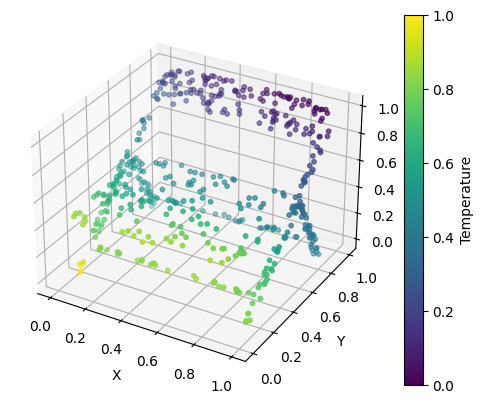

In [ ]:
import plotly.graph_objects as go
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルをデバイスに転送
model.to(device)

# 球上の点群を生成
#points = create_points(num_points=3000, radius=1.0).to(device)
points = create_chair_points().to(device)
# 温度推論
with torch.no_grad():
    predicted_temperatures = model(points).cpu().numpy().astype(float)  # データ型を指定
    predicted_temperatures =  predicted_temperatures

print(predicted_temperatures.max())
print(predicted_temperatures.min())


# 3Dプロットのセットアップ
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
normalized_temp = (predicted_temperatures - predicted_temperatures.min()) / \
                  (predicted_temperatures.max() - predicted_temperatures.min())
# 温度に応じたカラーマッピング
sc = ax.scatter(points[:, 0].cpu().numpy(),
                points[:, 1].cpu().numpy(),
                points[:, 2].cpu().numpy(),
                c=normalized_temp,
                cmap='viridis',  # カラーマップの指定
                s=10)  # ポイントサイズ

# カラーバーの追加
cb = plt.colorbar(sc)
cb.set_label('Temperature')

# 軸ラベル
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
